In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

In [3]:
img = mpimg.imread('camera_cal/calibration11.jpg')
image_shape = img.shape
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

In [4]:
def get_thresholded_image(img):
    
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

(768, 1023, 3)


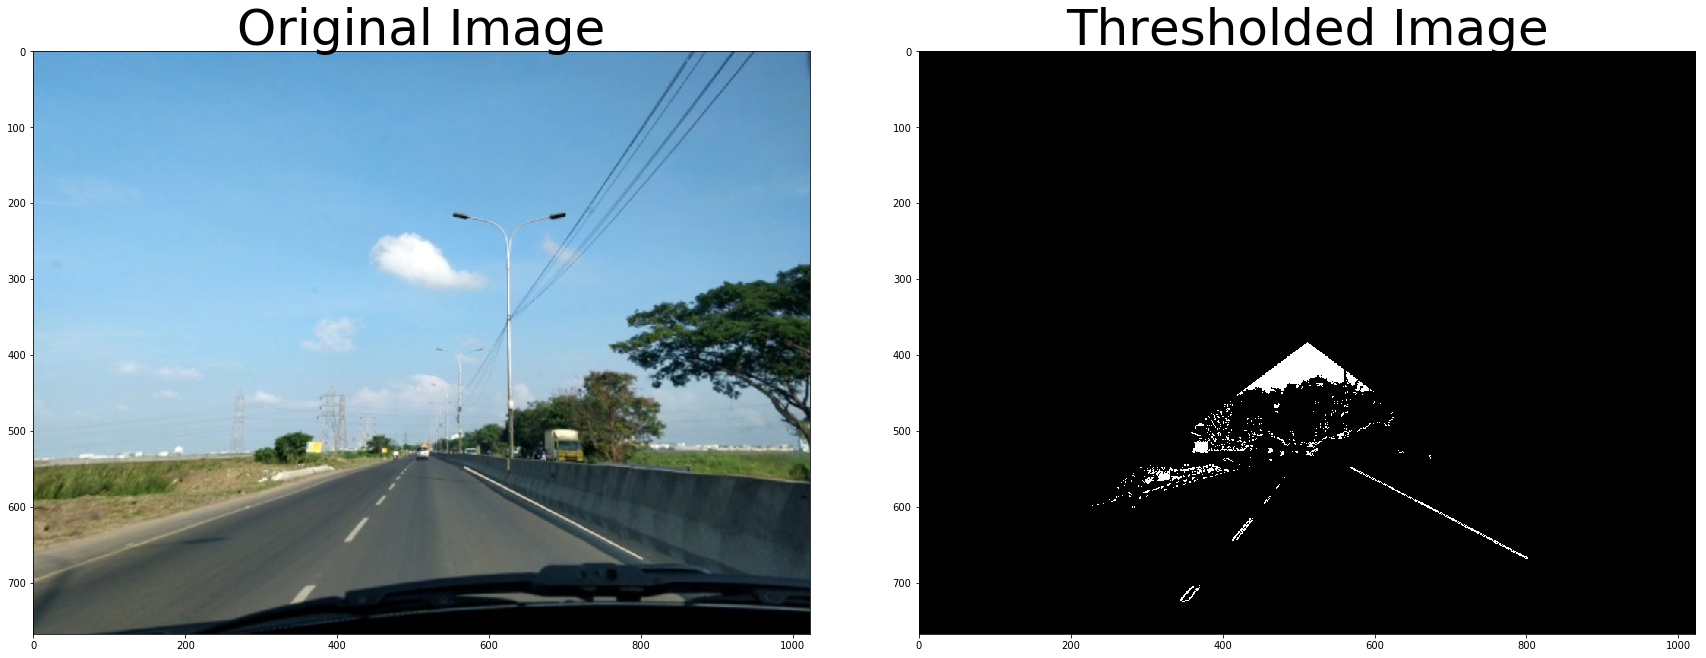

In [5]:
img = mpimg.imread('test_images/hindistan33.jpg')
thresholded = get_thresholded_image(img)
print(img.shape)
img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

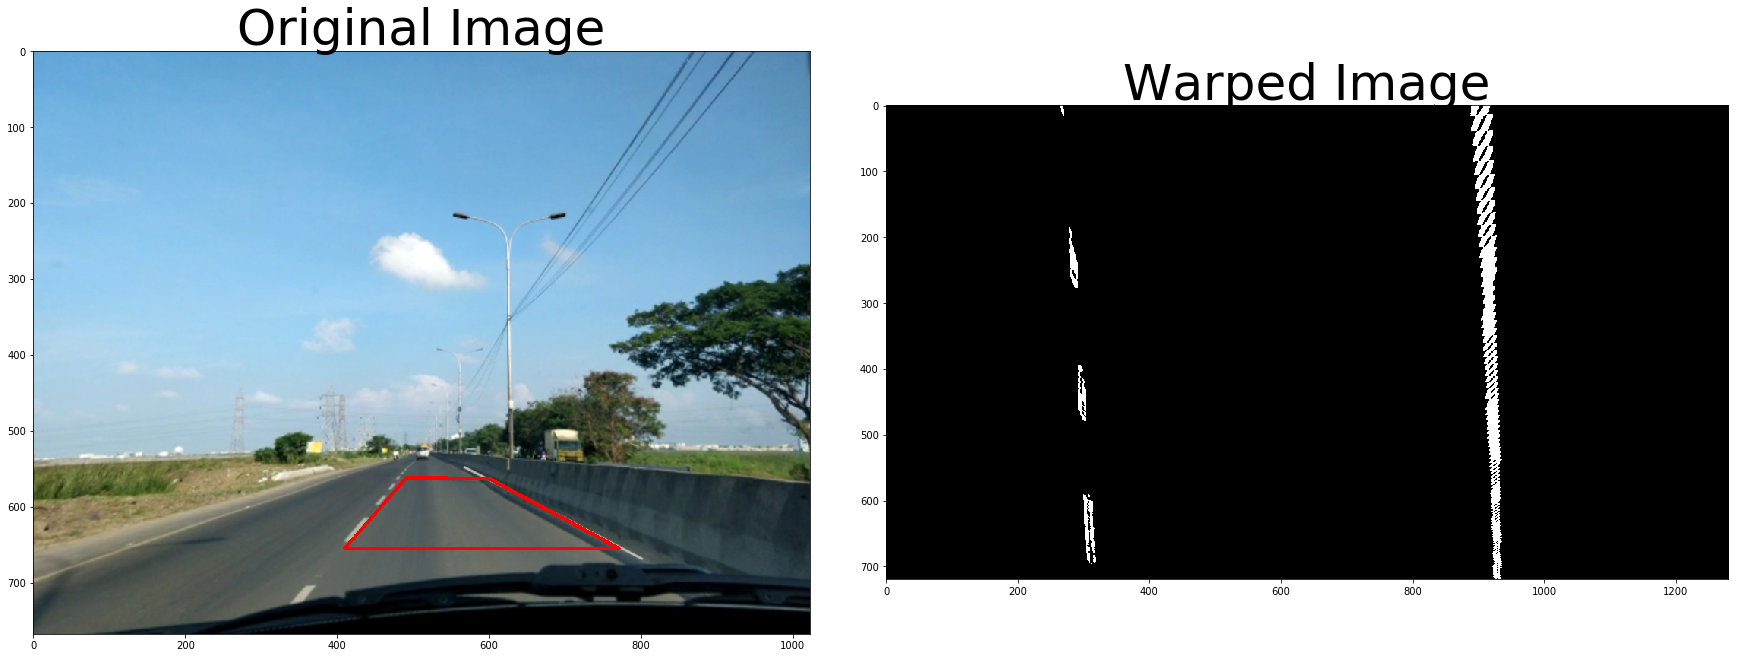

In [6]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [410,655] #220,720
bottom_right = [771, 655]
top_left = [491, 562]
top_right = [600, 563]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

302 924


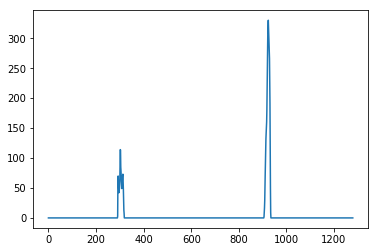

In [7]:
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

(720, 0)

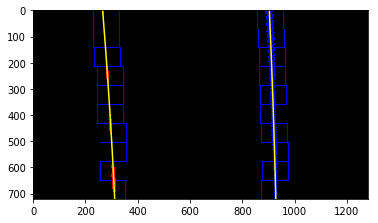

In [8]:
out_img = np.dstack((warped, warped, warped))*255

non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

Lane width approx. =  2.08255186482  meter


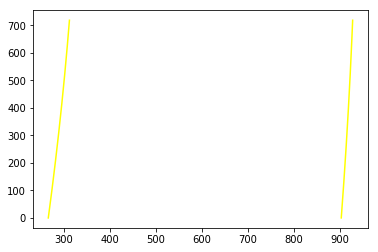

In [23]:
#hsvFrame = cv2.cvtColor(out_img,cv2.COLOR_RGB2HSV)
#plt.imshow(warped)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
approx = right_x_predictions[int(np.size(y_points)/2)] - left_x_predictions[int(np.size(y_points)/2)]
a = (bottom_right[0] + bottom_left[0])/2
b = (top_right[0] + top_left[0])/2
res = (b + a) / 2
fixedParameter = (res) / (img.shape[1])
result =(approx/1023) * 3.405405405405403
print("Lane width approx. = ",result ," meter" ) #3.405405405405403
#bottom_left = [410,655] #220,720
#bottom_right = [771, 655]
#top_left = [491, 562]
#top_right = [600, 563]

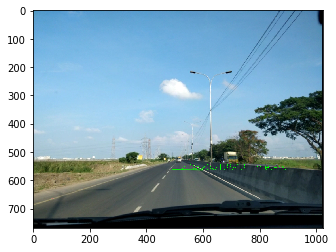

In [29]:
road = cv2.imread("test_images/hindistan33.jpg",1)
cv2.line(road, (491, 562), (600, 563),(0,255,0), thickness=2, lineType=cv2.LINE_AA)
cv2.putText(road, (np.str(result) + " meters"), (520, 562), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
cv2.imshow("Lane Width",road)
cv2.waitKey(0)
cv2.destroyAllWindows()
road2 = cv2.cvtColor(road,cv2.COLOR_BGR2RGB)
plt.imshow(road2)